# Smart Money Footprint Reversal (SMFR) – Long Setup by ChatGPT - Strategy - Backtesting 

### Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [8]:
def prepare_data(df):
    # Detect stop hunts (price breaks a previous low but closes higher)
    df['Swing_Low'] = df['Low'] < df['Low'].rolling(20).min().shift(1)
    df['Stop_Hunt'] = df['Swing_Low'] & (df['Close'] > df['Low'])  

    # Volume confirmation (higher than average)
    df['High_Volume'] = df['Volume'] > df['Volume'].rolling(10).mean() * 1.5  

    # Bullish confirmation (strong green candle after stop hunt)
    df['Bullish_Engulfing'] = (df['Close'] > df['Open']) & (df['Close'].shift(1) < df['Open'].shift(1)) & (df['Close'] > df['Open'].shift(1))

    # Combine conditions
    df['SMFR_Long'] = df['Stop_Hunt'] & df['High_Volume'] & df['Bullish_Engulfing']
    return df

In [9]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [10]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.SMFR_Long[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if signal == True:
            buy_price = close_price
            sl = buy_price - 3
            tp = buy_price + 6
            self.buy(size=1, sl=sl, tp=tp)

In [11]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [12]:
stats

Start                     2020-11-02 09:00:00
End                       2025-02-25 14:45:00
Duration                   1576 days 05:45:00
Exposure Time [%]                    0.866172
Equity Final [$]                    1490.3685
Equity Peak [$]                    1538.79414
Return [%]                            -0.6421
Buy & Hold Return [%]               51.072103
Return (Ann.) [%]                   -0.150751
Volatility (Ann.) [%]                0.966651
Sharpe Ratio                        -0.155952
Sortino Ratio                        -0.24179
Calmar Ratio                        -0.047903
Max. Drawdown [%]                   -3.146986
Avg. Drawdown [%]                   -0.407489
Max. Drawdown Duration      497 days 00:50:00
Avg. Drawdown Duration       72 days 16:24:00
# Trades                                   66
Win Rate [%]                        39.393939
Best Trade [%]                       0.554217
Worst Trade [%]                     -0.361243
Avg. Trade [%]                    

In [13]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,446,457,922.97681,926.5,3.52319,0.003817,2020-11-12 13:35:00,2020-11-12 14:30:00,None,0 days 00:55:00
1,1,1152,1169,981.29430,982.3,1.00570,0.001025,2020-12-02 13:05:00,2020-12-02 14:30:00,None,0 days 01:25:00
2,1,2595,2595,1191.15724,1187.6,-3.55724,-0.002986,2021-01-12 14:20:00,2021-01-12 14:20:00,None,0 days 00:00:00
3,1,4569,4576,1188.75652,1187.5,-1.25652,-0.001057,2021-03-15 13:55:00,2021-03-15 14:30:00,None,0 days 00:35:00
4,1,4735,4778,1203.76102,1209.5,5.73898,0.004768,2021-03-19 09:20:00,2021-03-19 14:20:00,None,0 days 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...
61,1,50638,50649,1351.30527,1347.8,-3.50527,-0.002594,2024-10-24 10:55:00,2024-10-24 13:15:00,None,0 days 02:20:00
62,1,50949,50960,1337.40110,1334.0,-3.40110,-0.002543,2024-11-01 11:20:00,2024-11-01 13:40:00,None,0 days 02:20:00
63,1,51577,51579,1268.88055,1265.3,-3.58055,-0.002822,2024-11-19 14:05:00,2024-11-19 14:15:00,None,0 days 00:10:00
64,1,52385,52391,1343.40290,1340.0,-3.40290,-0.002533,2024-12-11 13:25:00,2024-12-11 13:55:00,None,0 days 00:30:00


In [14]:
# bt.plot()

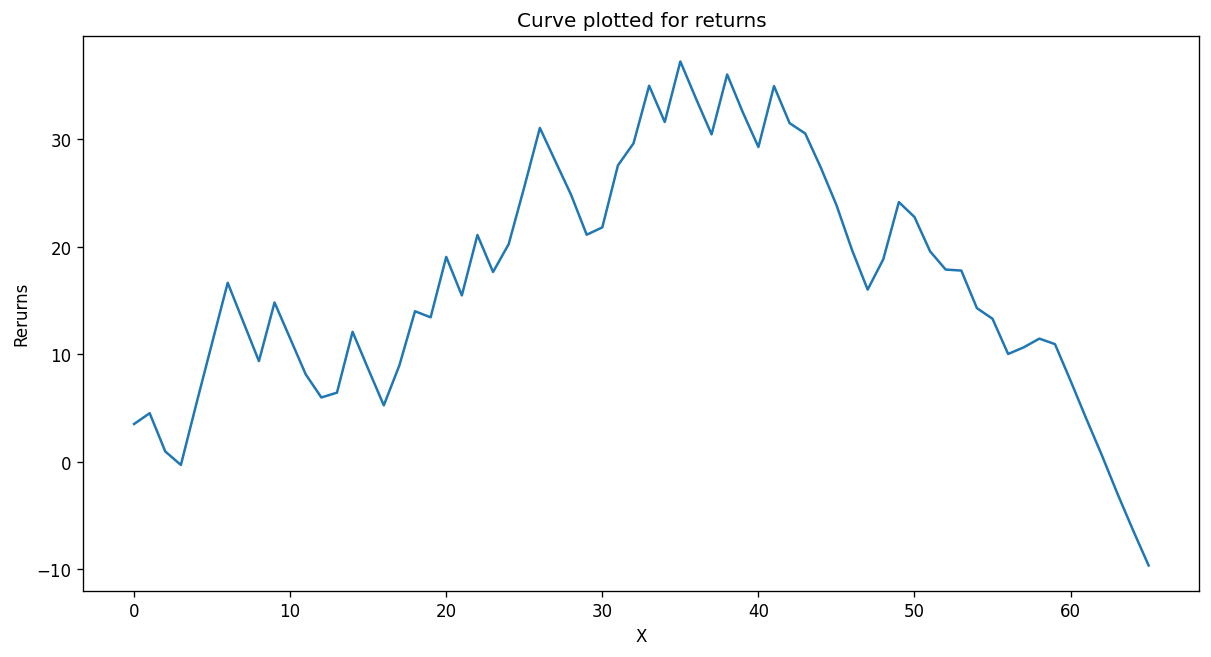

In [15]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()